# Visualize Interpretation Approach for GTEx Blood Features

**Gregory Way, 2018**

Visualizing the interpretation of compression results across two VAE models.
This informs downstream analyses.

Additional main and supplementary figures are generated in a later notebook.

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(dplyr))

## Visualize the Compression Interpretation Implementation

In [2]:
results_file <- file.path('results', 'gtex_vae_example_interpret_compression.tsv')
interpret_data_df <- (
    readr::read_tsv(results_file,
                    col_types = readr::cols(.default = readr::col_character(),
                                            raw_score = readr::col_double(),
                                            z_score = readr::col_double()))
    )

interpret_data_df$full_feature <- factor(interpret_data_df$full_feature,
                                  levels = c("vae_0_two", "vae_1_two", "vae_0_three",
                                             "vae_1_three", "vae_2_three"))

head(interpret_data_df)

model_type,full_feature,variable,raw_score,z_score
real,vae_2_three,Keratinocytes_HPCA_3,-10.901510,-33.32254
real,vae_1_two,Keratinocytes_HPCA_3,-10.564337,-30.32630
real,vae_1_three,Sebocytes_FANTOM_3,-9.071379,-25.20342
real,vae_2_three,Keratinocytes_ENCODE_1,-6.572572,-23.50536
real,vae_1_three,Sebocytes_FANTOM_1,-8.317615,-21.20593
real,vae_2_three,Sebocytes_FANTOM_1,-6.761970,-19.13752


In [3]:
vae_labels <- c("vae_0_two" = "z = 2 (Feature 0)",
                "vae_1_two" = "z = 2 (Feature 1)",
                "vae_0_three" = "z = 3 (Feature 0)",
                "vae_1_three" = "z = 3 (Feature 1)",
                "vae_2_three" = "z = 3 (Feature 2)")

vae_colors <- c("#db70ff", "#9b41f4", "#9af441", "#29b239", "#277544")

In [4]:
color_logic <- (interpret_data_df$z_score > 13 | interpret_data_df$z_score < -18)

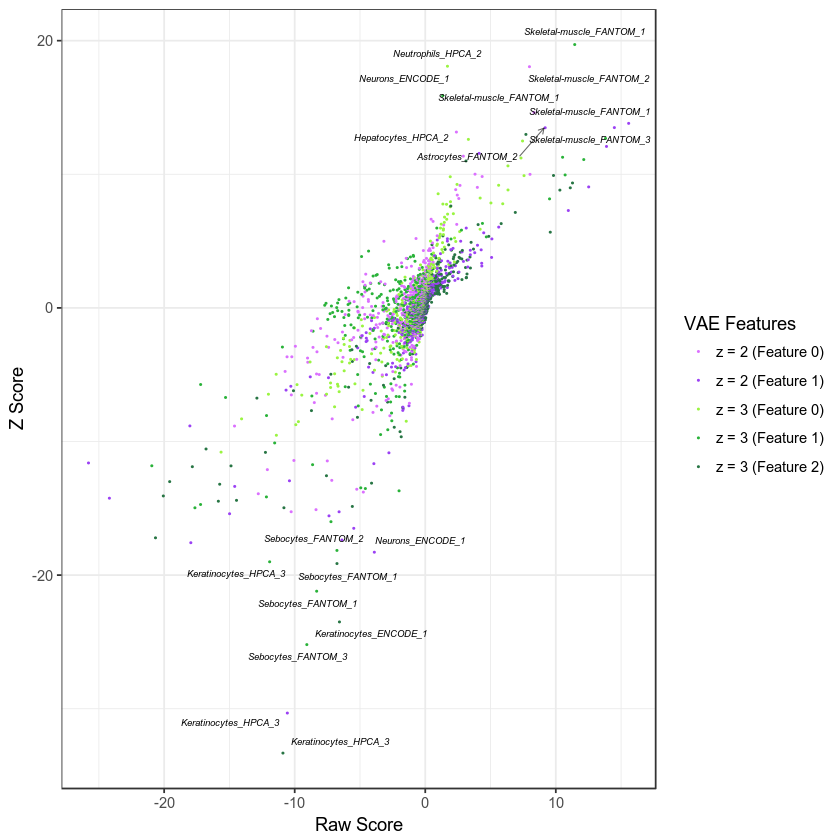

In [5]:
ggplot(interpret_data_df, aes(x = raw_score, y = z_score)) +
  geom_point(aes(color = full_feature), size = 0.2) +
  scale_color_manual(name = "VAE Features",
                     values = vae_colors,
                     labels =  vae_labels) +
  geom_text_repel(data = subset(interpret_data_df, color_logic),
                  arrow = arrow(length = unit(0.01, "npc")),
                  segment.size = 0.3,
                  segment.alpha = 0.6,
                  size = 2,
                  fontface = "italic",
                  point.padding = 0.1,
                  aes(x = raw_score, y = z_score, label = variable)) +
  xlab("Raw Score") +
  ylab("Z Score") +
  theme_bw()

fig_file <- file.path("figures", "interpret_compression_vae_neutrophils.png")
ggsave(fig_file, height = 4.5, width = 6, dpi = 500)

## Visualize the Overrepresentation results

In [6]:
results_file <- file.path('results', 'gtex_vae_example_overrepresentation.tsv')
overrep_data_df <- (
    readr::read_tsv(results_file,
                    col_types = readr::cols(.default = readr::col_integer(),
                                            variable = readr::col_character(),
                                            full_feature = readr::col_character(),
                                            odds = readr::col_double(),
                                            pval = readr::col_double(),
                                            tailed = readr::col_character()))
    )

overrep_data_df$full_feature <- factor(overrep_data_df$full_feature,
                                       levels = c("vae_0_two", "vae_1_two", "vae_0_three",
                                                  "vae_1_three", "vae_2_three"))

overrep_data_df$neg_log10_p <- -log10(overrep_data_df$pval)
head(overrep_data_df %>% dplyr::arrange(desc(neg_log10_p)))

variable,pval,odds,full_feature,tailed,neg_log10_p
Keratinocytes_FANTOM_3,2.455426e-22,18.49730,vae_1_three,neg,21.60987
Keratinocytes_FANTOM_2,1.569034e-21,18.27418,vae_1_three,neg,20.80437
Keratinocytes_FANTOM_1,1.069778e-19,11.36356,vae_1_three,neg,18.97071
Keratinocytes_HPCA_3,3.081031e-19,22.05901,vae_1_three,neg,18.51130
Skeletal-muscle_FANTOM_2,1.833130e-18,26.29440,vae_0_two,pos,17.73681
Keratinocytes_HPCA_2,1.561197e-17,17.05444,vae_1_three,neg,16.80654


In [7]:
color_logic <- overrep_data_df$neg_log10_p > 10

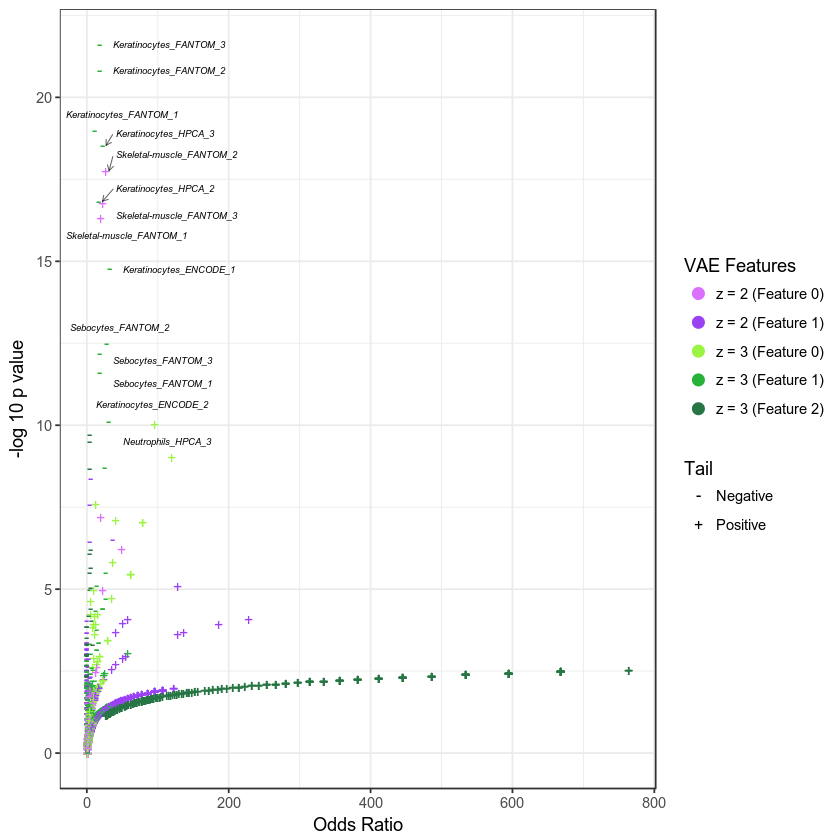

In [8]:
ggplot(overrep_data_df, aes(x = odds, y = neg_log10_p, shape = tailed)) +
  geom_point(aes(color = as.factor(full_feature)), size = 3) +
  scale_color_manual(name = "VAE Features",
                     values = vae_colors,
                     labels =  vae_labels) +
  scale_shape_manual(name = "Tail",
                     values = c("-", "+"),
                     labels = c("pos" = "Positive",
                                "neg" = "Negative")) +
  geom_text_repel(data = subset(overrep_data_df, color_logic),
                  arrow = arrow(length = unit(0.01, "npc")),
                  segment.size = 0.3,
                  segment.alpha = 0.6,
                  size = 2,
                  fontface = "italic",
                  point.padding = 0.3,
                  aes(x = odds, y = neg_log10_p, label = variable)) +
  xlab("Odds Ratio") +
  ylab("-log 10 p value") +
  theme_bw()

fig_file <- file.path("figures", "overrepresentation_vae_neutrophils_tailed.png")
ggsave(fig_file, height = 4, width = 6, dpi = 500)

## Compare BioBombe Network Projection Approach with Overrepresentation

### Combine Results and Plot in Single Figure

In [9]:
combined_results_df <- overrep_data_df %>%
    dplyr::full_join(interpret_data_df, by = c('variable', 'full_feature'))

head(combined_results_df)

variable,pval,odds,full_feature,tailed,neg_log10_p,model_type,raw_score,z_score
Keratinocytes_FANTOM_3,2.455426e-22,18.49730,vae_1_three,neg,21.60987,real,-17.642717,-14.96365
Keratinocytes_FANTOM_2,1.569034e-21,18.27418,vae_1_three,neg,20.80437,real,-17.210515,-14.71681
Keratinocytes_FANTOM_1,1.069778e-19,11.36356,vae_1_three,neg,18.97071,real,-20.945504,-11.81928
Keratinocytes_HPCA_3,3.081031e-19,22.05901,vae_1_three,neg,18.51130,real,-11.919360,-19.00494
Skeletal-muscle_FANTOM_2,1.833130e-18,26.29440,vae_0_two,pos,17.73681,real,7.981099,18.05253
Keratinocytes_HPCA_2,1.561197e-17,17.05444,vae_1_three,neg,16.80654,real,-12.166610,-14.14869


In [10]:
color_logic <- (combined_results_df$z_score > 13 |
                combined_results_df$z_score < -18 |
                combined_results_df$neg_log10_p > 13)

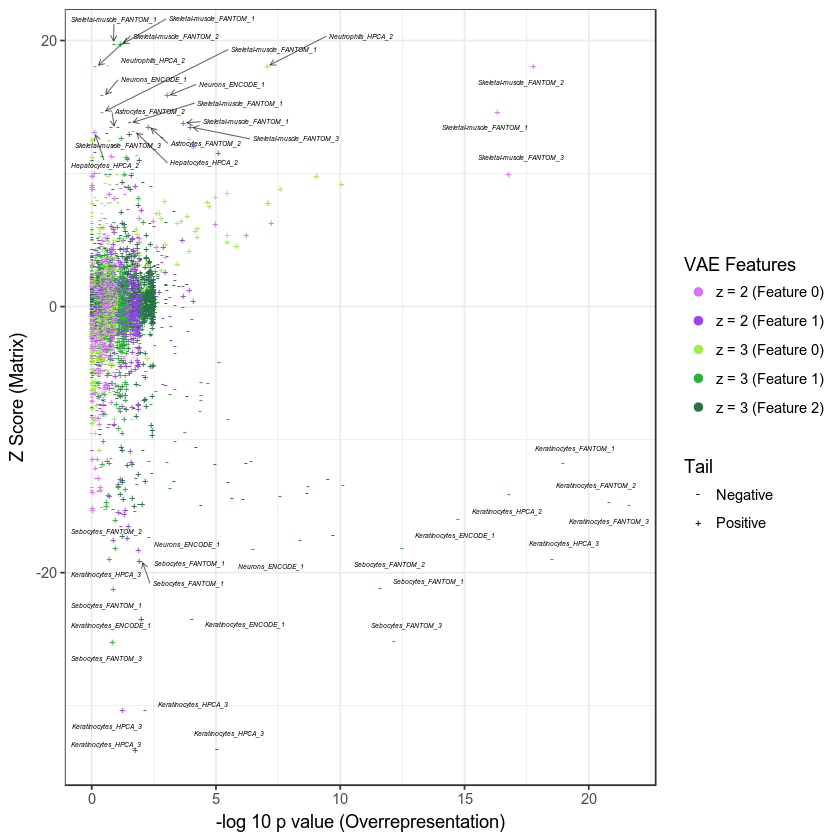

In [11]:
ggplot(combined_results_df,
       aes(x = neg_log10_p,
           y = z_score,
           shape = tailed)) +
  geom_point(aes(color = as.factor(full_feature)), size = 2) +
  scale_color_manual(name = "VAE Features",
                     values = vae_colors,
                     labels =  vae_labels) +
  scale_shape_manual(name = "Tail",
                     values = c("-", "+"),
                     labels = c("pos" = "Positive",
                                "neg" = "Negative")) +
  geom_text_repel(data = subset(combined_results_df, color_logic),
                  arrow = arrow(length = unit(0.01, "npc")),
                  segment.size = 0.3,
                  segment.alpha = 0.6,
                  size = 1.4,
                  fontface = "italic",
                  point.padding = 0.3,
                  aes(x = neg_log10_p, y = z_score, label = variable)) +
  ylab("Z Score (Matrix)") +
  xlab("-log 10 p value (Overrepresentation)") +
  theme_bw()

fig_file <- file.path("figures", "full_comparison_vae_neutrophils_tailed.png")
ggsave(fig_file, height = 4, width = 6, dpi = 500)

## Determine which features are most differential between VAE z = 2 and VAE z = 3

In [12]:
file <- file.path('results', 'gtex_vae_example_differentiating_features.tsv')
feature_info_df <- readr::read_tsv(file,
                                   col_types = readr::cols(.default = readr::col_double(),
                                                  ggplot(feature_info_df, aes(x=three, y=two)) +
    geom_point(alpha = 0.5, size = 0.6, shape = 16, color = ifelse(color_logic, "red", "grey50")) +
    theme_bw() +
    theme(axis.text.x = element_text(size = 8),
          axis.text.y = element_text(size = 8),
          axis.title = element_text(size = 8)) +
    geom_abline(intercept = 0, slope = 1, linetype = 'dashed') +
    coord_fixed() +
    geom_text_repel(data = subset(feature_info_df, color_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    segment.size = 0.3,
                    segment.alpha = 0.6,
                    size = 1.5,
                    fontface = "italic",
                    box.padding = 0.55,
                    point.padding = 0.15,
                    aes(x = three, y = two, label = variable)) +
    xlab("Z Score Enrichment for VAE z = 3") +
    ylab("Z Score Enrichment for VAE z = 2")

fig_file <- file.path("figures", "vae_feature_differences_2vs3.png")
ggsave(fig_file, height = 4, width = 6, dpi = 500)         variable = readr::col_character()))

In [13]:
color_logic = feature_info_df$abs_diff > 3.5 | feature_info_df$two > 13  | feature_info_df$three > 13

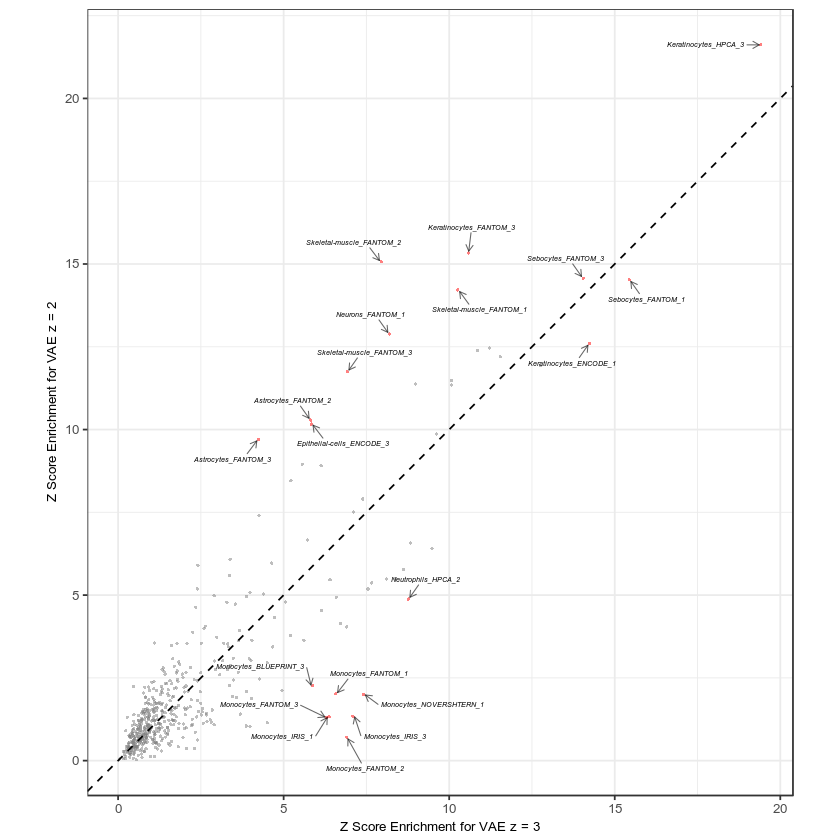

In [14]:
ggplot(feature_info_df, aes(x=three, y=two)) +
    geom_point(alpha = 0.5, size = 0.6, shape = 16, color = ifelse(color_logic, "red", "grey50")) +
    theme_bw() +
    theme(axis.text.x = element_text(size = 8),
          axis.text.y = element_text(size = 8),
          axis.title = element_text(size = 8)) +
    geom_abline(intercept = 0, slope = 1, linetype = 'dashed') +
    coord_fixed() +
    geom_text_repel(data = subset(feature_info_df, color_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    segment.size = 0.3,
                    segment.alpha = 0.6,
                    size = 1.5,
                    fontface = "italic",
                    box.padding = 0.55,
                    point.padding = 0.15,
                    aes(x = three, y = two, label = variable)) +
    xlab("Z Score Enrichment for VAE z = 3") +
    ylab("Z Score Enrichment for VAE z = 2")

fig_file <- file.path("figures", "vae_feature_differences_2vs3.png")
ggsave(fig_file, height = 4, width = 6, dpi = 500)